<a href="https://colab.research.google.com/github/Pravalika1812/Consumer-Complaint-Classification/blob/main/Bert_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

#### Import Library

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AdamW

In [ ]:
drive.mount('/content/drive/', force_remount=True)
trainPath = '/content/drive/MyDrive/NLP/NLP_PROJECT3/filtered_complaints_train_data.csv'
testPath = '/content/drive/MyDrive/NLP/NLP_PROJECT3/filtered_complaints_test_data.csv'

Mounted at /content/drive/


In [ ]:
# Read the CSV data into DataFrames
trainData = pd.read_csv(trainPath)
testData = pd.read_csv(testPath)

In [ ]:
trainData.head()

,Unnamed: 0,Date received,narrative,product_category
0,0,2022-04-07,"['please', 'advised', 'listed', 'recently', 'r...",credit_reporting
1,1,2023-11-05,"['approved', 'grant', 'haf', 'cover', 'mortgag...",mortgages_and_loans
2,2,2023-07-10,"['victim', 'trading', 'years', 'finally', 'got...",debt_collection
3,3,2021-12-10,"['reviewing', 'credit', 'card', 'statement', '...",credit_card
4,4,2023-08-06,"['placed', 'order', 'curling', 'irons', 'via',...",credit_card


In [ ]:
# Drop the remaining columns that are not important.
columns_to_drop = ['Unnamed: 0']
trainData.drop(columns=columns_to_drop, inplace=True)

In [ ]:
trainData.shape

(140000, 3)

In [ ]:
trainData.head()

,Date received,narrative,product_category
0,2022-04-07,"['please', 'advised', 'listed', 'recently', 'r...",credit_reporting
1,2023-11-05,"['approved', 'grant', 'haf', 'cover', 'mortgag...",mortgages_and_loans
2,2023-07-10,"['victim', 'trading', 'years', 'finally', 'got...",debt_collection
3,2021-12-10,"['reviewing', 'credit', 'card', 'statement', '...",credit_card
4,2023-08-06,"['placed', 'order', 'curling', 'irons', 'via',...",credit_card


In [ ]:
type(np.array(trainData['narrative']))

numpy.ndarray

In [ ]:
len(trainData['narrative'].unique())

136869

#### Convert categories into numeric form

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming your original labels are in a list
original_labels = ['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']

# Create a label encoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(original_labels)

In [ ]:
numeric_labels

array([0, 1, 2, 3, 4])

In [ ]:
# Split the dataset
from sklearn.model_selection import train_test_split
subset1, subset2 = train_test_split(trainData, test_size=0.90, random_state=64)

In [ ]:
subset1["product_category"].value_counts()

product_category
credit_card            2831
credit_reporting       2830
debt_collection        2822
mortgages_and_loans    2770
retail_banking         2747
Name: count, dtype: int64

In [ ]:
xTrain = np.array(subset1["narrative"])
yTrain = np.array(subset1["product_category"])
xTest = np.array(testData["narrative"])
yTest = np.array(testData["product_category"])

In [ ]:
# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)

# freeze the all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two layers
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
type(xTrain)

numpy.ndarray

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# Convert numpy array to a list of strings
xTrain_list = [str(entry) for entry in xTrain]

# Encode the training and test data
train_encodings = tokenizer(xTrain_list, truncation=True, padding=True, return_tensors='pt', max_length=256)

In [ ]:
yTrain

array(['credit_card', 'mortgages_and_loans', 'retail_banking', ...,
       'retail_banking', 'credit_reporting', 'credit_reporting'],
      dtype=object)

In [ ]:
# Create PyTorch tensors for labels
yTrain = torch.tensor(label_encoder.transform(yTrain))

# Create training and test datasets
train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], yTrain)

In [ ]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Train the model
from tqdm import tqdm
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)
model.train()

progress_bar = tqdm(train_loader, desc=f'Epoch 1', leave=False)

for batch in progress_bar:
    input_ids, attention_mask, labels = batch
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    # Update the progress bar with the current loss
    progress_bar.set_postfix({'Loss': loss.item()}, refresh=True)

print(f'Training for Epoch 1 completed.')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
                                                                      

Training for Epoch 1 completed.


In [ ]:
# Drop the remaining columns that are not important.
columns_to_drop = ['Unnamed: 0']
testData.drop(columns=columns_to_drop, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming your original labels are in a list
original_labels = ['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']

# Create a label encoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(original_labels)

In [ ]:
# Create a DataFrame with randomly sampled entries for each category
testData = testData.sample(2000, random_state=42).reset_index(drop=True)

print(testData["product_category"].value_counts())

product_category
retail_banking         422
credit_card            406
credit_reporting       394
debt_collection        390
mortgages_and_loans    388
Name: count, dtype: int64


In [ ]:
import numpy as np

xTest = np.array(testData["narrative"])
yTest = np.array(testData["product_category"])

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# Convert numpy array to a list of strings
xTest_list = [str(entry) for entry in xTest]

# Encode the training and test data
test_encodings = tokenizer(xTest_list, truncation=True, padding=True, return_tensors='pt', max_length=256)

# Create a DataLoader for the test set
yTest = torch.tensor(label_encoder.transform(yTest))
test_dataset = torch.utils.data.TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], yTest)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Evaluate the model using the evaluate method
model.eval()
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]  # Move all batch tensors to the same device
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())

# Inverse transform predicted labels back to their original categories
decoded_predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Evaluate the performance
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

# Decode the true labels for evaluation
true_labels = label_encoder.inverse_transform(yTest.cpu().numpy())

accuracy = accuracy_score(true_labels, decoded_predicted_labels)
f1 = f1_score(true_labels, decoded_predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, decoded_predicted_labels)
class_report = classification_report(true_labels, decoded_predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.775
F1 Score: 0.7744470574407951
Confusion Matrix:
[[308  25  12  25  36]
 [ 21 295  47  29   2]
 [ 22  58 268  35   7]
 [ 15  13  10 341   9]
 [ 61   0   8  15 338]]
Classification Report:
                     precision    recall  f1-score   support

        credit_card       0.72      0.76      0.74       406
   credit_reporting       0.75      0.75      0.75       394
    debt_collection       0.78      0.69      0.73       390
mortgages_and_loans       0.77      0.88      0.82       388
     retail_banking       0.86      0.80      0.83       422

           accuracy                           0.78      2000
          macro avg       0.78      0.77      0.77      2000
       weighted avg       0.78      0.78      0.77      2000



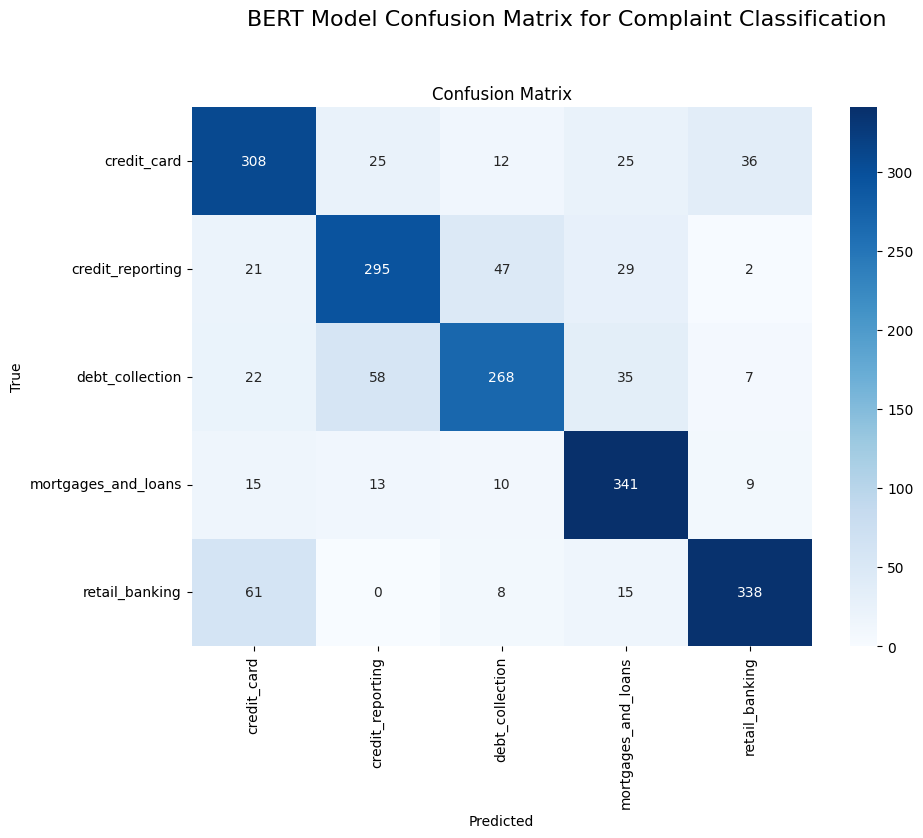

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the labels
labels = ['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.suptitle('BERT Model Confusion Matrix for Complaint Classification', y=1.02, fontsize=16)
plt.show()
